In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import sys
sys.path.append('./utils')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats
import rft_reconstruct_traj as rft
from scipy.io import loadmat

In [3]:
def rec_traj_from_sim(angleArray,L,dt,alpha=35.):
    theta = -angleArray
    ds = L/(theta.shape[0])
    skel = rft.get_skels(theta,L)
    X = skel[:,:,0]
    Y = skel[:,:,1]
    
    XCM, YCM, UX, UY, UXCM, UYCM, TX, TY, NX, NY, I, OMEG = rft.get_RBM(skel,L,ds,dt)
    DX, DY, ODX, ODY, VX, VY, Xtil, Ytil, THETA = rft.subtractRBM(X, Y, XCM, YCM, UX, UY, UXCM, UYCM, OMEG, dt)
    TX,TY = rft.lab2body(TX, TY, THETA)
    VX,VY = rft.lab2body(VX, VY, THETA)
    
    RBM = rft.posture2RBM(TX,TY,Xtil,Ytil,VX,VY,L,I,ds,alpha)
    XCM_recon,YCM_recon,THETA_recon = rft.integrateRBM(RBM,dt,THETA)
    Xrecon = np.vstack([XCM_recon,YCM_recon]).T
    Xskel_recon,Yskel_recon =  rft.addRBMRotMat(Xtil, Ytil, XCM_recon, YCM_recon,THETA_recon, XCM, YCM, THETA)
    return Xrecon,Xskel_recon,Yskel_recon

In [4]:
def get_widths(n_points,worm_length=1,s_skel=100):
    """
    Calculates (x,y) coordinates of the worm centerline from the tangent angle (theta) vector
    """
    num_centerline_joints = n_points
    widths = np.ones(n_points)
    widths[:int(n_points*.2)] = 2*np.linspace(.1,.5,int(n_points*.2))
    widths[int(n_points*.8):] = np.linspace(.01,1,int(n_points*.2)+1)[::-1]
    return widths*s_skel

def plot_skel(skel,widths,s,s_skel,c='k'):
    Xskel = s*(skel-skel.mean(axis=0))
    plt.scatter(Xskel[:,0],Xskel[:,1],c=c,s=widths)
    plt.plot(Xskel[:-1,0],Xskel[:-1,1],c='w',lw=1.5,solid_capstyle='round')
    plt.scatter(Xskel[2,0],Xskel[2,1],c='w',s=s_skel*.08)
    plt.scatter(Xskel[6,0],Xskel[6,1],c='w',s=s_skel*.15)
    plt.plot(Xskel[:6,0],Xskel[:6,1],c='w',lw=.008*s_skel,solid_capstyle='round')

def plot_worm_traj(Xskel_example,X_example,kt,s,s_skel,widths):
    plt.figure(figsize=(9,5))
    plt.subplot(1,2,1)
    plot_skel(Xskel_example[:,kt],widths,s,s_skel)
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.text(3.5,-9,'t={:.2f} mins'.format(kt*dt/60))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,2,2)
    trange = 500
    colors_t = plt.cm.Greys(np.linspace(0.3,1,trange))
    plt.plot(X_example[:kt][:,0],X_example[:kt][:,1],c='gray',alpha=.5,lw=3)
    plt.scatter(X_example[kt][0],X_example[kt][1],c='k',s=50)
    for k_,t in enumerate(np.arange(kt-trange,kt)):
        plt.plot(X_example[t:t+2,0],X_example[t:t+2,1],c=colors_t[k_],lw=3)
    plt.plot([12,12+L],[-14,-14],c='k')
    plt.text(11.3,-16,'1bl')
    plt.xlim(-30,15)
    plt.ylim(-17,28)
    plt.xlabel('$x_{lab}$',fontsize=20)
    plt.ylabel('$y_{lab}$',fontsize=20)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])

In [5]:
n_worms=12
frameRate=16.
dt=1/frameRate
mat = loadmat('../data/Foraging_N2/shapes.mat')
theta_ensemble = np.array(mat['theta_ensemble'],dtype=float)
stepper_to_mm = 788
wormCM = ma.array(mat['wormCm'][:,::2,:],dtype=float)/stepper_to_mm
wormCM[wormCM==0] = ma.masked
headTail_theta_w = np.array(mat['wormHeadTailTheta'],dtype=float)
pix_to_mm = 405
wormLength = ma.array(mat['wormLength'],dtype=float)/pix_to_mm
wormLength[wormLength==0]=ma.masked    

L_w = np.array([np.median(wormLength[kw].compressed())for kw in range(n_worms)])

In [6]:
eigenworms_matrix = np.loadtxt('../data/Foraging_N2/EigenWorms.csv', delimiter=',').astype(np.float32)

kw=7
ksim=3

L=L_w[kw]

f = h5py.File('../data/tseries_sims/tseries_sims_{}.h5'.format(kw),'r')
ts = np.array(f['ts_smooth_sims'])[ksim]
thetas = ts.dot(eigenworms_matrix[:,:5].T)
f.close()    
angleArray = thetas.T

In [7]:
alpha=30.
Xrecon,Xskel_recon,Yskel_recon =  rec_traj_from_sim(angleArray,L,dt,alpha=alpha)

In [8]:
Xskel_example = np.array([Xskel_recon,Yskel_recon]).T
X_example = Xrecon

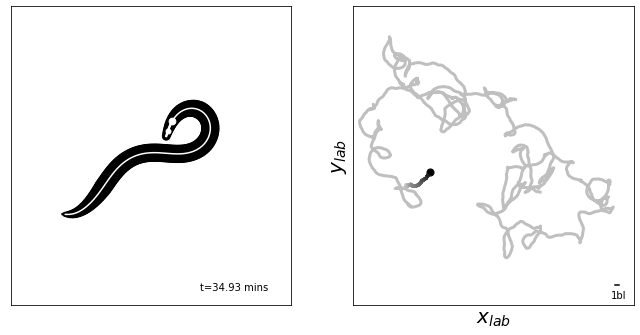

In [9]:
kt=33530
s=25
s_skel=300
widths = get_widths(Xskel_example[:,0].shape[0],s_skel=s_skel)
plot_worm_traj(Xskel_example,X_example,kt,s,s_skel,widths)
plt.show()

In [10]:
def plot_angle_posture(kt,thetas_sim,thetas_data,widths,s,s_skel):
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,1)
    plt.imshow(thetas_sim.T,aspect=5,vmax=np.pi,vmin=-np.pi,cmap='viridis')
    plt.axvline(kt,ls='--',c='k')
    plt.ylabel(r'$\theta$')
    plt.xlabel('time(s)')
    plt.subplot(2,2,2)
    plot_skel(Xskel_sim[:,kt],widths,s,s_skel)
    plt.xlim(-15,15)
    plt.ylim(-15,15)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

    plt.subplot(2,2,3)
    plt.imshow(thetas_data.T,aspect=5,vmax=np.pi,vmin=-np.pi,cmap='viridis')
    plt.axvline(kt,ls='--',c='k')
    plt.ylabel(r'$\theta$')
    plt.xlabel('time(s)')
    plt.subplot(2,2,4)
    plot_skel(Xskel_data[:,kt],widths,s,s_skel)
    plt.xlim(-15,15)
    plt.ylim(-15,15)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.subplots_adjust(wspace=-.15, 
                        hspace=-.3)

In [11]:
mat=h5py.File('../data/Foraging_N2/PNAS2011-DataStitched.mat','r')
refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()

In [12]:
kw=0
ksim=3
f = h5py.File('../data/tseries_sims/tseries_sims_{}.h5'.format(kw),'r')
ts = np.array(f['ts_smooth_sims'])[ksim][1:960]
thetas_sim = ts.dot(eigenworms_matrix[:,:5].T)
f.close()    
thetas_data = tseries_w[kw][1:960].dot(eigenworms_matrix[:,:5].T)

In [13]:
Xrecon,Xskel_recon,Yskel_recon =  rec_traj_from_sim(thetas_sim.T,1,dt,alpha=alpha)
Xskel_sim = np.array([Xskel_recon,Yskel_recon]).T


Xrecon,Xskel_recon,Yskel_recon =  rec_traj_from_sim(thetas_data.T,1,dt,alpha=alpha)
Xskel_data = np.array([Xskel_recon,Yskel_recon]).T

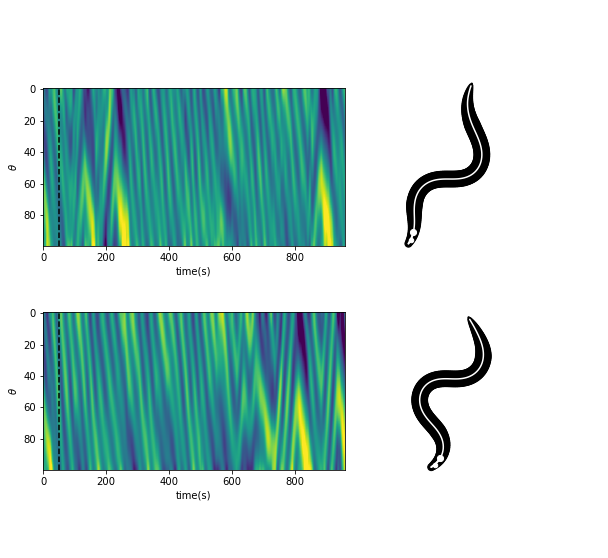

In [15]:
kt=50
s=20
s_skel=250
widths = get_widths(Xskel_sim[:,0].shape[0],s_skel=s_skel)
plot_angle_posture(kt,thetas_sim,thetas_data,widths,s,s_skel)
plt.show()